<a href="https://colab.research.google.com/github/Seligmann/carvana-image-masking-challenge/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 
import os
# import PIL
import numpy as np
import pathlib
import pandas as pd

import tensorflow_datasets as tfds
from PIL import Image
import cv2

In [33]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [34]:
import os

# # Upload the API token.
# def get_kaggle_credentials():
#   token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
#   token_file = os.path.join(token_dir, "kaggle.json")
#   if not os.path.isdir(token_dir):
#     os.mkdir(token_dir)
#   try:
#     with open(token_file,'r') as f:
#       pass
#   except IOError as no_file:
#     try:
#       from google.colab import files
#     except ImportError:
#       raise no_file
    
#     uploaded = files.upload()
    
#     if "kaggle.json" not in uploaded:
#       raise ValueError("You need an API key! see: "
#                        "https://github.com/Kaggle/kaggle-api#api-credentials")
#     with open(token_file, "wb") as f:
#       f.write(uploaded["kaggle.json"])
#     os.chmod(token_file, 600)

# get_kaggle_credentials()

In [35]:
# import kaggle

In [36]:
# Download competition data to /content
# !kaggle competitions download -c carvana-image-masking-challenge

In [37]:
metadata_csv = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/metadata.csv'
train_masks_csv = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/train_masks.csv'
train_data = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/train'
train_masks_data = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/train_masks'
test_data = '/content/drive/MyDrive/MyDrive/carvana-image-masking-challenge/images/test'

In [38]:
metadata_df = pd.read_csv(metadata_csv)
train_masks_df = pd.read_csv(train_masks_csv)

In [39]:
metadata_df.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [40]:
train_masks_df.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [41]:
train_files = os.listdir(train_data)
train_mask_files = os.listdir(train_masks_data)
test_files = os.listdir(test_data)
print("Train files count:", len(train_files))
print("Train mask files count:", len(train_mask_files))
print("Test files count:", len(test_files))

Train files count: 5088
Train mask files count: 5088
Test files count: 100064


In [42]:
# metadata_df.rename({'image_id':'image_name'}, axis=1, inplace=True) # ? Pretty sure this was already done
# metadata_df.head()

In [43]:
# Get unique ids for each of the photos in train and test datasets
train_ids = []
for n in train_files:
  train_ids.append(n.split("_")[0])

test_ids = []
for n in test_files:
  test_ids.append(n.split("_")[0])

train_mask_ids = []
for n in train_mask_files:
  train_mask_ids.append(n.split("_")[0])

In [72]:
# Using the training images and their masks, we want to create pairs of 
# NumPy matrices, in order to display each training image and it's mask as 
# images, as well as get their dimensions and pixel-wise information.

# But, not all training images have an associated mask. Each training, test, and
# training mask file has an ID. If some training image has a training mask,
# they will share an id.

# Note: One ID is shared across multiple files, as each car has a set of images.

# Example format of each file:
# * train_files[0]: 0cdf5b5d0ce1_01.jpg
# * train_mask_files[0]: cf65b1c5e147_09_mask.gif
# * test_files[0]: 3a2e36d7cd6a_01.jpg
# * train_ids[0]: cf65b1c5e147
# * train_mask_ids[0]: cf65b1c5e147
# * test_ids[0]: 0004d4463b50

def GetCarImageFiles(car_image_id, get_mask=False):
  if get_mask:
    if car_image_id in train_mask_ids:
      for n in train_mask_files:
        if car_image_id in n:
          return [train_masks_data + "/" + n]
    else:
      raise Exception("Input image does not have a mask ID")
  elif car_image_id in train_ids:
    for n in train_files:
      if car_image_id in n:
        return [train_data + "/" + n]
  elif car_image_id in test_ids:
    for n in test_files:
      if car_image_id in n:
        return [test_data + "/" + n]
  else:
    raise Exception("No test, train, or mask image with this ID found")

def GetImageMatrix(image_path):
  img = Image.open(image_path)
  return np.asarray(img, dtype=np.uint8)

Image shape: (1280, 1918, 3)
Image type: uint8
Mask shape: (1280, 1918)
Mask type: uint8


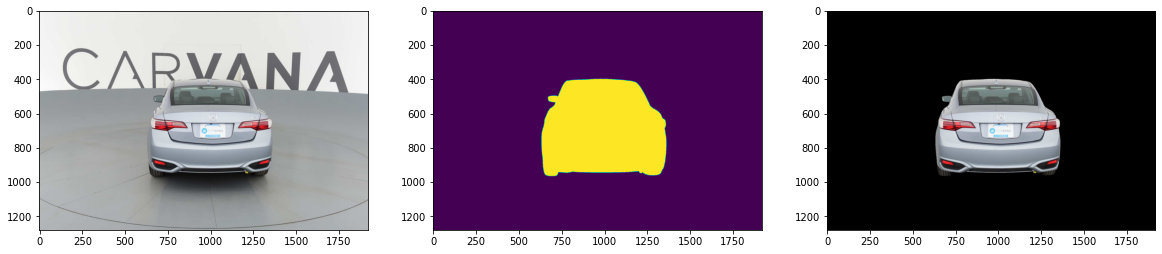

In [94]:
# Display single car with associated mask

# Get image and mask
path_to_mask = GetCarImageFiles(train_ids[0], get_mask=True)
mask = GetImageMatrix(path_to_mask[0])
path_to_image = GetCarImageFiles(train_ids[0])
image = GetImageMatrix(path_to_image[0])
dest_and = cv2.bitwise_and(image, image, mask=mask)

print("Image shape:", image.shape)
print("Image type:", image.dtype)
print("Mask shape:", mask.shape)
print("Mask type:", mask.dtype)

plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.imshow(dest_and)